\begin{center}
\textbf{Authors} \\
Mattia Zanin - \href{mailto:mattia.zanin@studenti.unipd.it}{\texttt{mattia.zanin@studenti.unipd.it}} \\
Matteo Giorgi - \href{mailto:matteo.giorgi.1@tudenti.unipd.it}{\texttt{matteo.giorgi.1@tudenti.unipd.it}} \\
Enrico Zanello - \href{mailto:enrico.zanello@studenti.unipd.it}{\texttt{enrico.zanello@studenti.unipd.it}} \\
Luca Lo Buono - \href{mailto:luca.lobuono@studenti.unipd.it}{\texttt{luca.lobuono@studenti.unipd.it}}

\vspace{1cm}
\end{center}

## Plot of the time series

The first step of the analysis consists of plotting the raw time series in order to gain an initial understanding of its main characteristics.

From the plot, the series appears to fluctuate around a roughly constant level, without an evident long-term upward or downward trend. The variability of the observations seems relatively stable over time, with no clear signs of volatility clustering or explosive behavior.

Moreover, the series exhibits a recurrent oscillatory pattern, suggesting the possible presence of a seasonal or cyclical component. This visual inspection does not provide definitive evidence of stationarity, but it does not rule it
out either.

At this stage, the plot serves as a preliminary diagnostic tool. A formal assessment of stationarity will be carried out in the next step using both visual techniques and statistical tests.

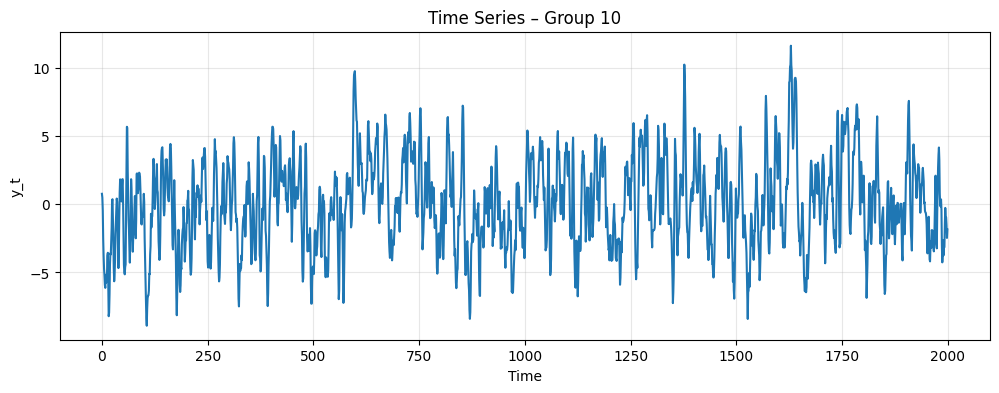

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the new dataset
df = pd.read_csv("arma12_seasonal_controlled_15series.csv")

# Select Group 10
y = df["series_10"].astype(float)

# Plot the series
plt.figure(figsize=(12, 4))
plt.plot(y)
plt.title("Time Series – Group 10")
plt.xlabel("Time")
plt.ylabel("y_t")
plt.grid(alpha=0.3)
plt.show()

## Check for stationarity

In [2]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
# The adfuller function returns a tuple of statistics
result = adfuller(y, 21)

# Extract and print the results
adf_stat = result[0]
p_value = result[1]
usedlag = result[2]
nobs = result[3]
critical_values = result[4]

print(f"ADF Statistic: {adf_stat}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Check stationarity
if p_value < 0.05:
    print("Result: The series is Stationary")
else:
    print("Result: The series is Non-Stationary")

ADF Statistic: -9.783542032993036
p-value: 6.635302025669602e-17
Critical Values:
   1%: -3.433643643742798
   5%: -2.862994949652858
   10%: -2.5675445538118042
Result: The series is Stationary


The stationarity of the series was formally assessed using the Augmented
Dickey–Fuller (ADF) test.

The null hypothesis of the ADF test is that the series contains a unit root,
i.e. it is non-stationary. The test returns a very small p-value, well below
standard significance levels. Therefore, we reject the null hypothesis and
conclude that the series is stationary.

As a consequence, no transformation (such as differencing) is required in order
to achieve stationarity, and the series can be directly modeled using ARMA
processes.

This result is consistent with the concept of **weak stationarity**, which
requires the mean and variance of the process to be finite and constant over
time, and the autocovariance structure to depend only on the lag and not on
time itself. No assumptions are made on higher-order moments or on the equality
of full joint distributions.

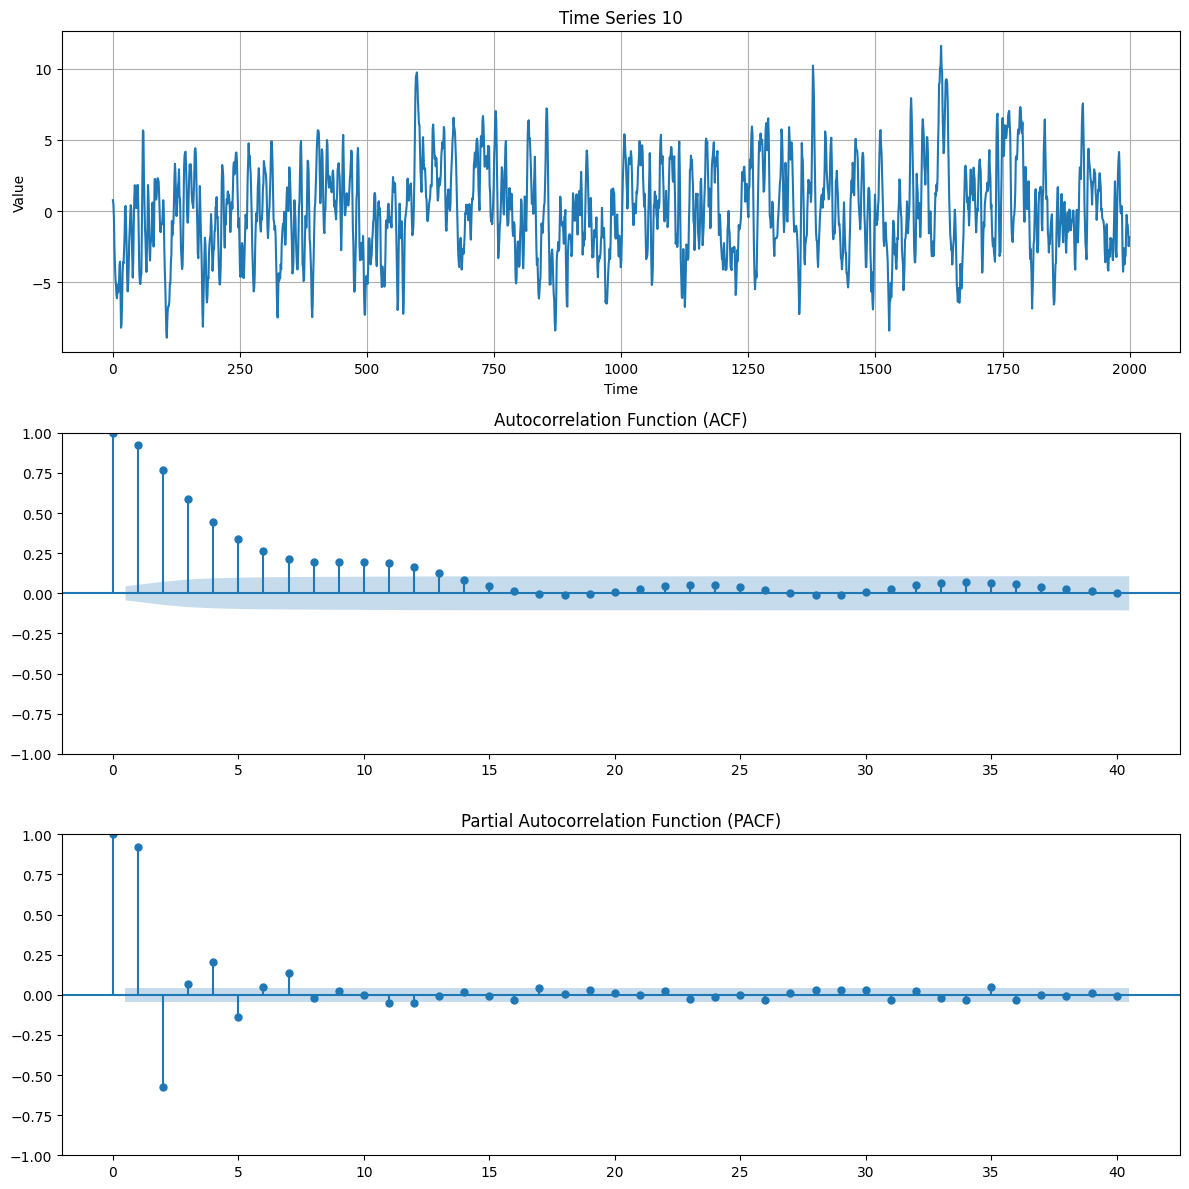

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Initialize the figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

# Plot the Time Series
ax1.plot(df["t"], y)
ax1.set_title("Time Series 10")
ax1.set_xlabel("Time")
ax1.set_ylabel("Value")
ax1.grid(True)

# Plot Autocorrelation (ACF)
plot_acf(y, ax=ax2, lags=40, title="Autocorrelation Function (ACF)")

# Plot Partial Autocorrelation (PACF)
plot_pacf(y, ax=ax3, lags=40, title="Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

The autocorrelation structure of the series was analyzed through the
Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF).

The ACF exhibits a smooth and gradual decay, remaining significantly different
from zero for several initial lags. This behavior is not compatible with a
pure MA process, which would display a sharp cutoff in the ACF, and instead
suggests the presence of autoregressive dynamics.

The PACF shows a small number of significant spikes at the first lags, followed
by values that mostly lie within the confidence bounds. This pattern indicates
that the dependence on past observations is captured by a low-order AR
component.

Overall, the absence of a clear cutoff in either the ACF or the PACF suggests
that neither a pure AR nor a pure MA model is sufficient. Instead, the observed
patterns are consistent with a mixed **ARMA** structure with low orders.

Based on this preliminary identification step, ARMA models with small values of
$p$ and $q$ are natural candidates for the series.


## ARMA model identification

In [4]:
from statsmodels.tsa.arima.model import ARIMA

# Candidate ARMA models
candidates = [
    (1, 0, 0),  # AR(1)
    (2, 0, 0),  # AR(2)
    (1, 0, 1),  # ARMA(1,1)
    (2, 0, 1),  # ARMA(2,1)
    (1, 0, 2),  # ARMA(1,2)
]

results = []

for order in candidates:
    try:
        # we remove the trend component by setting trend="n"
        model = ARIMA(y, order=order, trend="n")
        fit = model.fit()
        print(fit.summary())

        # we only have ARMA models here, we can ignore the 'd' parameter
        # so we use order[0] and order[2]
        results.append(
            {"model": f"ARMA({order[0]},{order[2]})", "AIC": fit.aic, "BIC": fit.bic}
        )
    except Exception as e:
        print(f"Model ARMA{order} failed: {e}")


results_df = pd.DataFrame(results).sort_values("AIC")
results_df

                               SARIMAX Results                                
Dep. Variable:              series_10   No. Observations:                 2000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3299.519
Date:                Mon, 15 Dec 2025   AIC                           6603.039
Time:                        14:50:43   BIC                           6614.241
Sample:                             0   HQIC                          6607.152
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9221      0.009    102.156      0.000       0.904       0.940
sigma2         1.5852      0.052     30.473      0.000       1.483       1.687
Ljung-Box (L1) (Q):                 559.62   Jarque-

,model,AIC,BIC
4,"ARMA(1,2)",5653.275490,5675.679100
3,"ARMA(2,1)",5807.114706,5829.518315
1,"ARMA(2,0)",5810.307591,5827.110298
2,"ARMA(1,1)",6048.781362,6065.584069
0,"ARMA(1,0)",6603.038797,6614.240602


Since the series is stationary, an ARMA model can be directly fitted. The
identification follows the Box–Jenkins methodology.

The inspection of the ACF and PACF suggests the presence of both autoregressive
and moving-average components with relatively low orders. Based on this
preliminary analysis, several candidate ARMA models were estimated.

Model comparison was carried out using information criteria. The table above
reports the AIC and BIC values for all candidate models. Among them, the
**ARMA(1,2)** (without constant) model achieves the lowest values of both AIC and BIC, indicating
the best balance between goodness of fit and model parsimony.

Furthermore, all parameters of the ARMA(1,2) model are statistically
significant, and the Ljung–Box test applied to the residuals does not reject the
null hypothesis of no autocorrelation. This indicates that the residuals behave
like white noise.

Therefore, **ARMA(1,2)** is selected as the final model for the series.

### Residual normality

The normality of the residuals was assessed using the Jarque–Bera test.

The test yields a p-value well above standard significance levels. Therefore,
we do not reject the null hypothesis of normality. This provides no evidence
against the assumption that the residuals are normally distributed.

Although normality is not strictly required for the consistency of ARMA
estimators, this result supports the adequacy of the model and facilitates
statistical inference.


\bibliographystyle{alpha}
\bibliography{references}